#### Importing the libraries 

In [1]:
import segyio
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from shutil import copyfile
from skimage import exposure
import pandas as pd
import openpyxl

#### Importing the segy file and converting it into DataFrame (Pandas)

In [2]:
filename='D:/abdullah/jup/seismic.segy'  # write path to seismic.segy file
f=segyio.open(filename, 'r+', strict=False, ignore_geometry=True)

In [3]:
print(type(filename))
print(type(f))

<class 'str'>
<class 'segyio.segy.SegyFile'>


In [4]:
frames = [pd.DataFrame(f.trace[i] for i in range(0,120120,1))]
print(type(frames))
result = pd.concat(frames)
print(type(result))
# result.to_excel('C:/Users/abdul/Downloads/ejaz1.xlsx', index=False)

<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [5]:
sg2=result.T

In [6]:
sg2 = pd.DataFrame(sg2.astype('float64'))

In [7]:
print((sg2.shape))

(1500, 120120)


#### handling missing shots

In [8]:
mis = [80,81,88,89,90,449,450,451,759,760,761]
slistc =list(range(1,1113))
slist=[0]*len(slistc)
for i in slistc:
    if i not in mis:
        slist[i-1]=i

#### basic geometry and parameters

In [9]:
so, dx, nt, fold = 262, 25, 120, 60
fs = 250  # sampling frequency
dt = 1 / fs  # sampling interval
td = 1500 * dt
df = 1 / td
dw = 2 * np.pi * df
t = np.arange(0, td, dt)

#### Function for extracting the 60 fold CMP gather from the 60 shot data 

In [10]:
def extsg(sg2, k):
    
    idx = slist.index(k)
    offsets = np.array([])
    i=0
    j=np.array([])
    while i < fold:
        if slist[i+idx]==0:
            i+=1
            # print('mis')
            continue
        offsets=np.append(offsets,np.array([so + 2*i*dx]))
        j = np.append(j, np.array([k*nt-1 + i*118]))
        i += 1
        
    sg = pd.DataFrame(0.0, index=range(1500), columns=range(len(j)))
    sg.iloc[:,0:len(j)] = sg2.iloc[:,j]
    return sg, offsets
    

#### Functions for NMO correction

In [11]:
def nmo_correction(sgn, dt, offsets, velocities): 
    # nmo = pd.DataFrame(0, index=range(sz[0]), columns=range(sz[1]))
    nmo = np.zeros_like(sgn)
    # print(nmo.iloc[1499,59])
    nsamples = 1500 #cmp.shape[0] 
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, x in enumerate(offsets):
            if t0*velocities<=8:
                # print('t0 = ', t0, ',vnmo= ', velocities, ',offset= ', x)
                break
            tt = reflection_time(t0, x, velocities)
            # print('t0 = ', t0, ',vnmo= ', velocities, ',offset= ', x, ', ref time = ', tt, ',xd = ', xd)
            amplitude = sample_trace(sgn[:, j], tt, dt) 
            if amplitude is not None: 
                nmo[i, j] = amplitude 
    return nmo

In [247]:
# def reflection_time(t0, x, vnmo): 
#     t = np.sqrt(t0**2 + x**2/vnmo**2) 
#     return t

In [221]:
# print(reflection_time(5.5, 1212, 1500))

5.5590344485351055


#### Modified reflection time to counter differential elevation in source and receivers

In [12]:
def reflection_time(t0,x,vnmo):
    xd = 4*x/(vnmo*t0-4)
    s1= np.sqrt((vnmo*t0/2)**2+((x+xd)/2)**2)
    s2= np.sqrt((vnmo*t0/2-4)**2 + ((x-xd)/2)**2)
    t= (s1+s2)/vnmo
    return t

In [13]:
from scipy.interpolate import CubicSpline 

def sample_trace(trace, time, dt): 
    before = int(np.floor(time/dt)) 
    N = trace.size 
    samples = np.arange(before-1, before + 3) 
    if any(samples < 0) or any(samples >= N): 
        amplitude = None 
    else: 
        times = dt*samples 
        amps = trace[samples] 
        interpolator = CubicSpline(times, amps) 
        amplitude = interpolator(time) # amplitude is ndarray of size 1 and shape == (). it is a scalar
        amplitude = amplitude[()] # converting ndarray to numpy.float64
    return amplitude

#### Balancing the traces to rms level

In [14]:
def balance_trace(trace):
    """
    Balance a single seismic trace to a common rms level.
    """
    # Calculate the rms value of the trace
    rms_value = np.sqrt(np.mean(trace ** 2))

    # Scale the trace to the common rms level (e.g., 1.0)
    balanced_trace = trace / rms_value

    return balanced_trace

def balance_seismic_data(seismic_data):
    """
    Balance all traces in a seismic data set to a common rms level.
    """
    balanced_seismic_data = np.zeros_like(seismic_data)

    # Balance each trace individually
    for i in range(seismic_data.shape[1]):
        balanced_seismic_data[:, i] = balance_trace(seismic_data[:, i])

    return balanced_seismic_data

#### Function for semblance coefficient

In [15]:
def sem(nmc):
    # k = 5
    seb = np.zeros((1500))
    for k in range(5,1495,1):
        sumnum=0
        sumden=0
        for j in range(k-5,k+6,1):
            sumnum += (np.sum(nmc[j,:]))**2
            sumden += np.sum(nmc[j,:]**2)
        if sumden != 0:
            seb[k] = sumnum/sumden/nmc.shape[1]
    return seb

In [16]:
def f_nmo_correction(sgn, dt, offsets, velocities): 
    # nmo = pd.DataFrame(0, index=range(sz[0]), columns=range(sz[1]))
    nmo = np.zeros_like(sgn)
    # print(nmo.iloc[1499,59])
    nsamples = 1500 #cmp.shape[0] 
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, x in enumerate(offsets):
            if t0*velocities[i]<=8:
                # print('t0 = ', t0, ',vnmo= ', velocities, ',offset= ', x)
                break
            tt = reflection_time(t0, x, velocities[i])
            # print('t0 = ', t0, ',vnmo= ', velocities, ',offset= ', x, ', ref time = ', tt, ',xd = ', xd)
            amplitude = sample_trace(sgn[:, j], tt, dt) 
            if amplitude is not None: 
                nmo[i, j] = amplitude 
    return nmo

#### CMP stack analysis (20 CMPs)

1


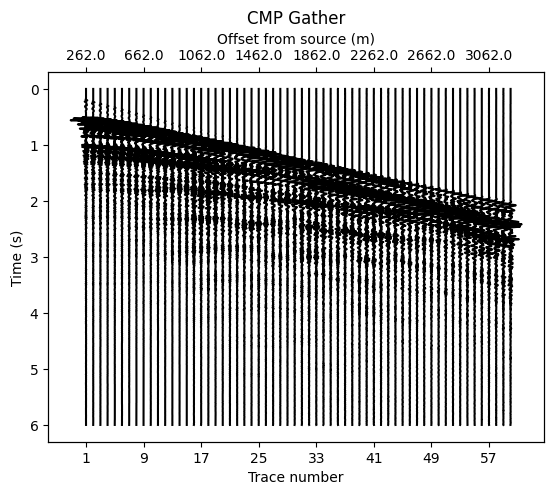

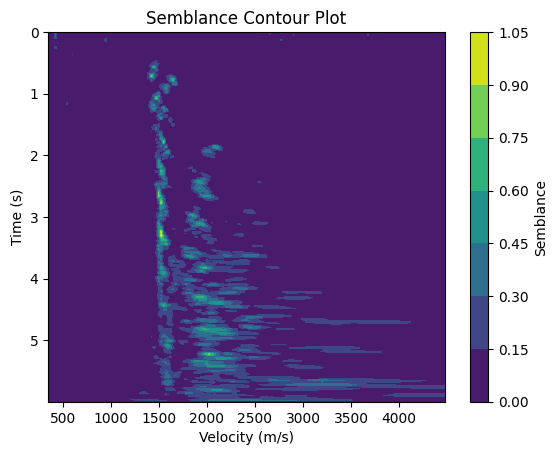

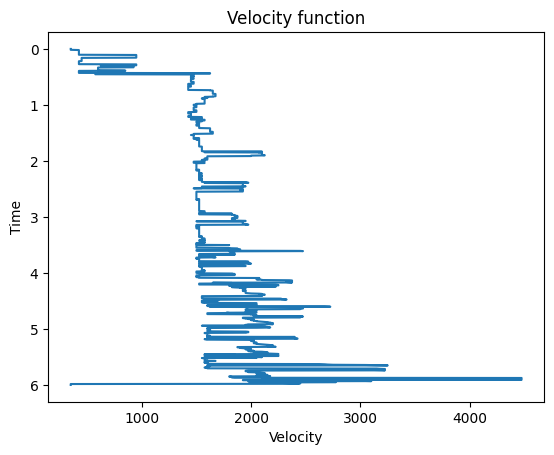

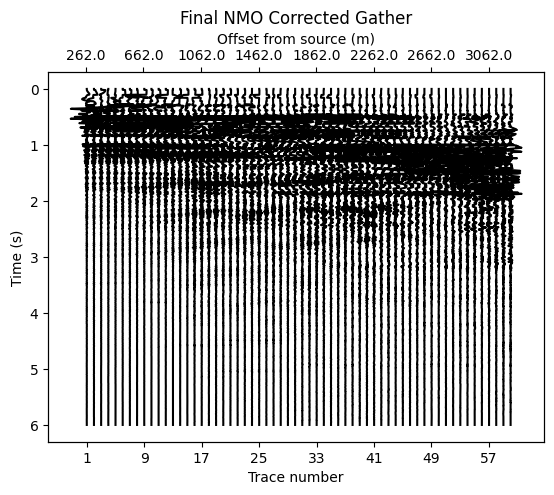

50


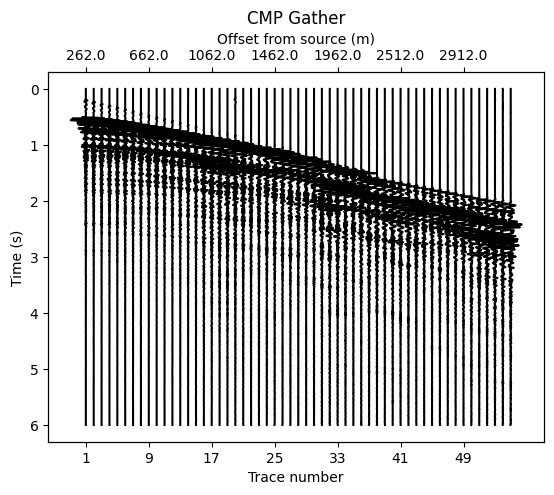

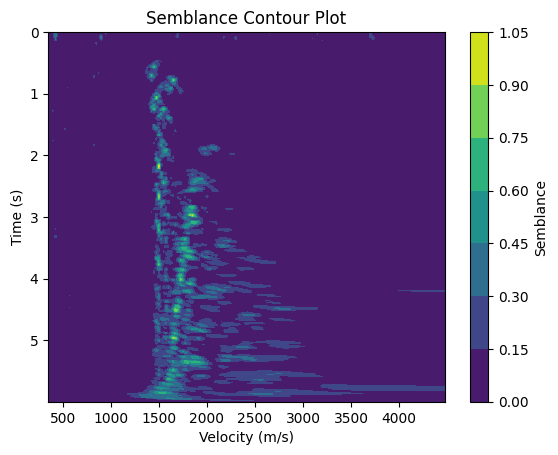

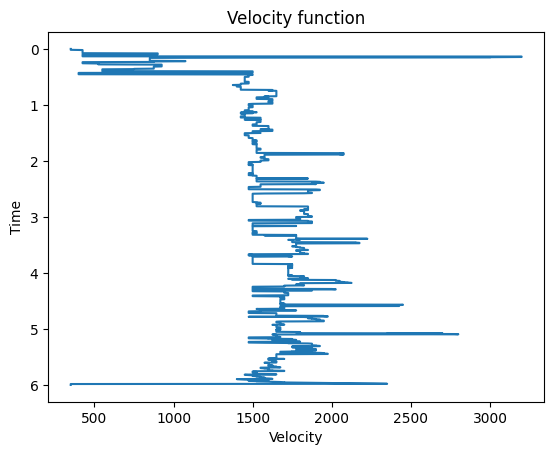

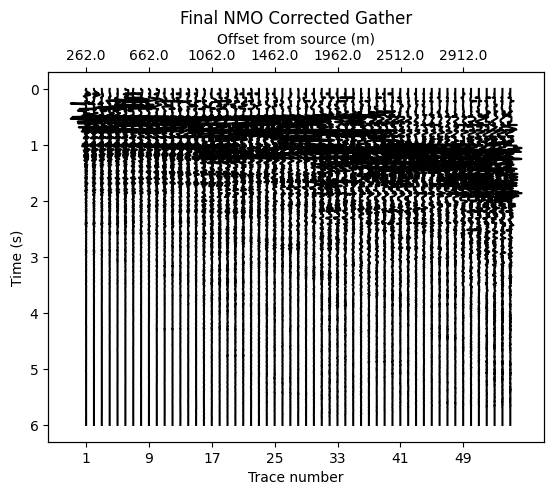

99


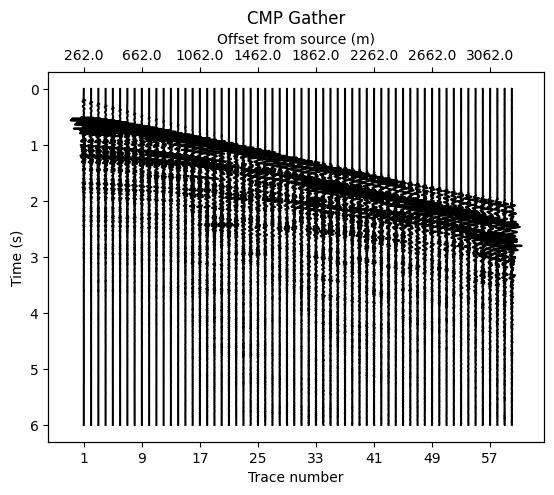

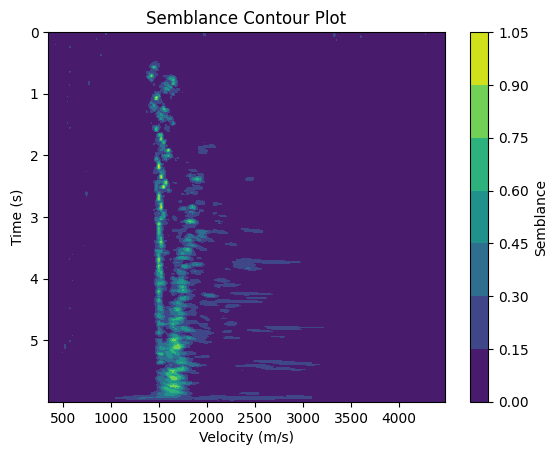

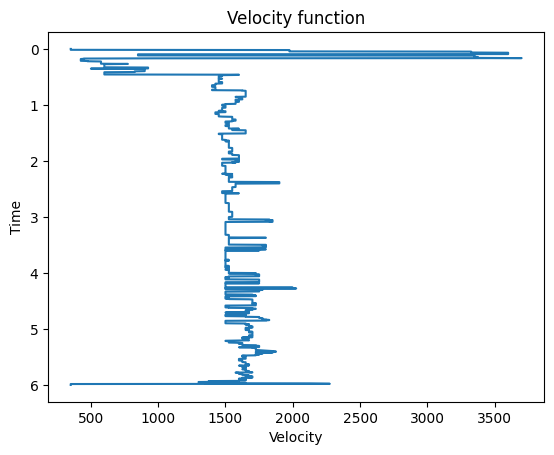

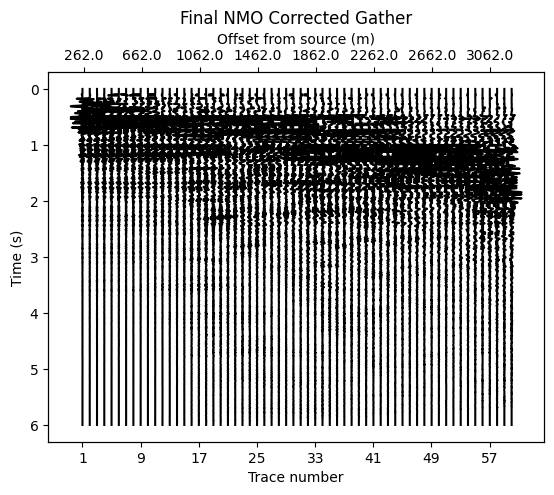

148


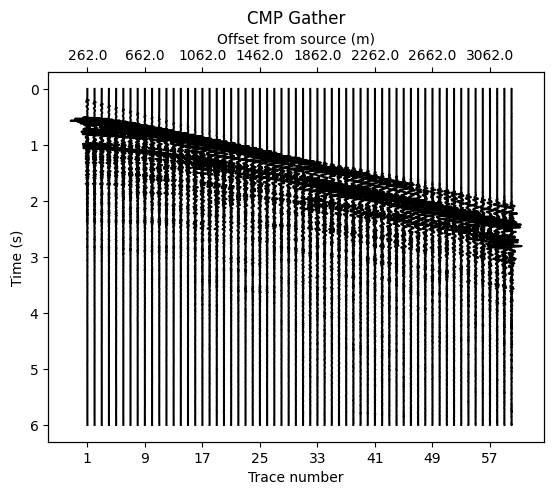

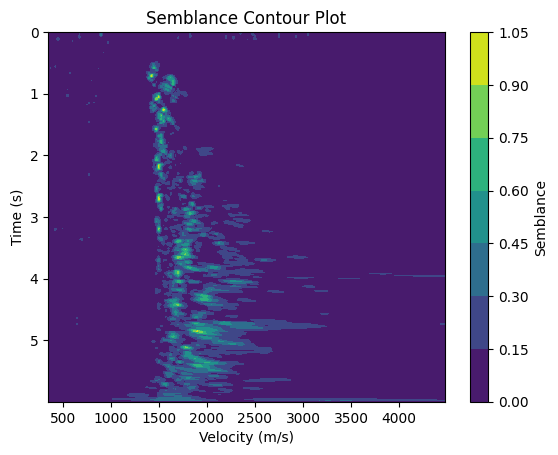

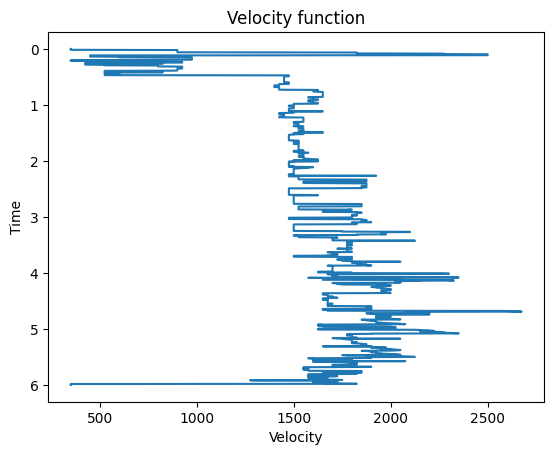

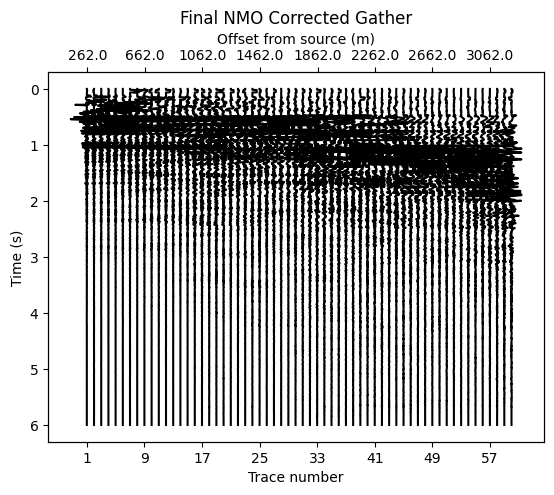

197


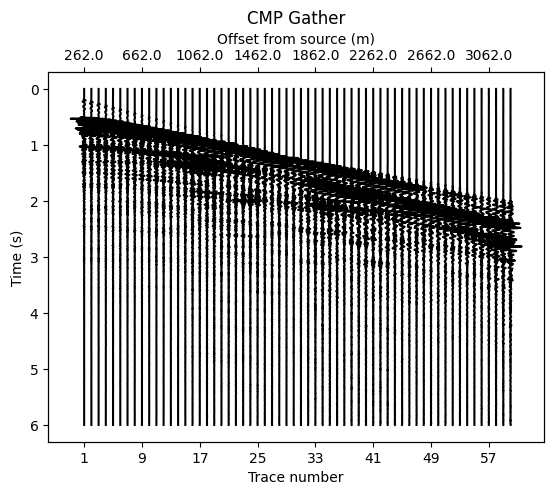

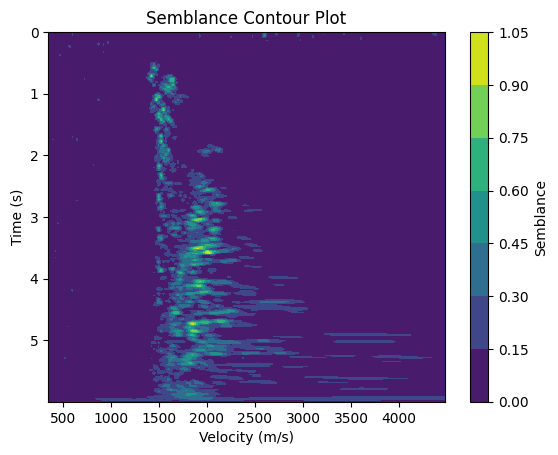

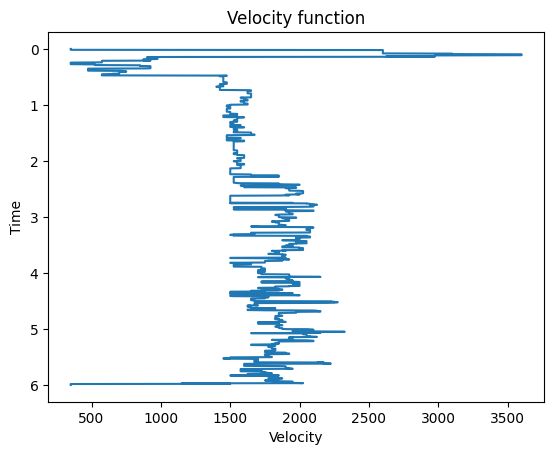

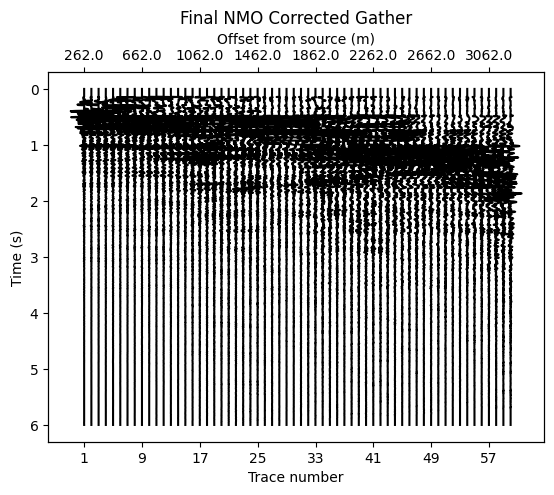

246


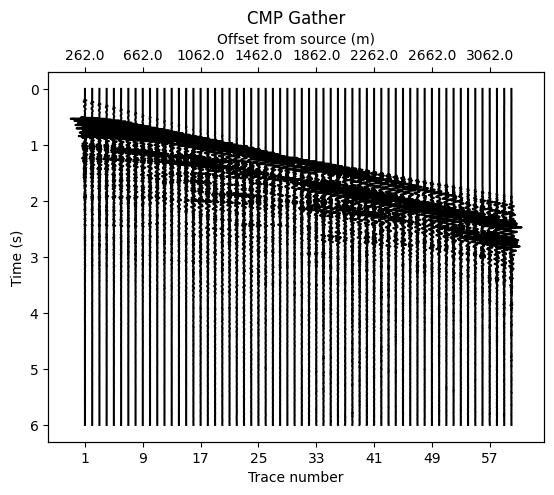

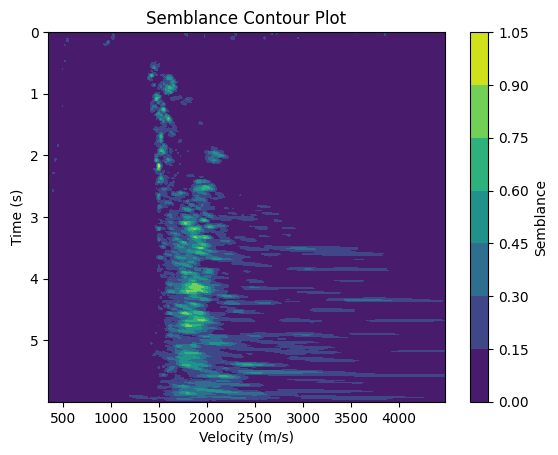

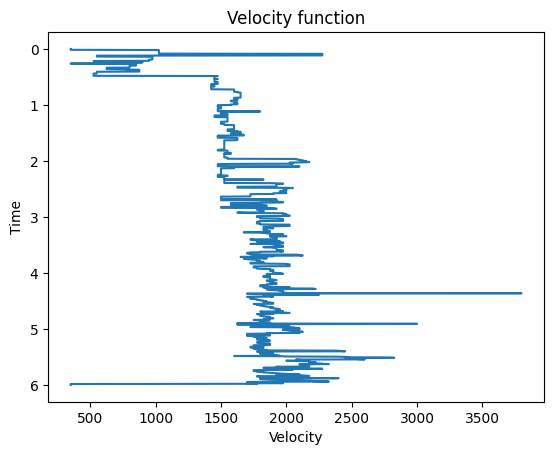

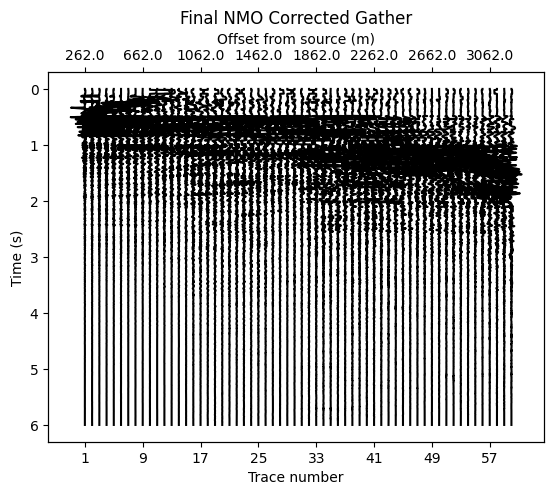

295


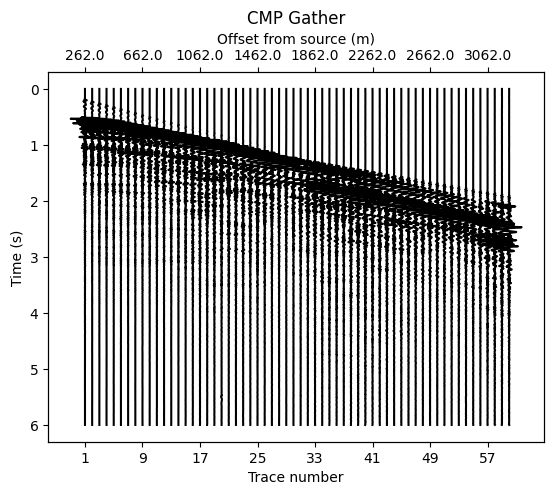

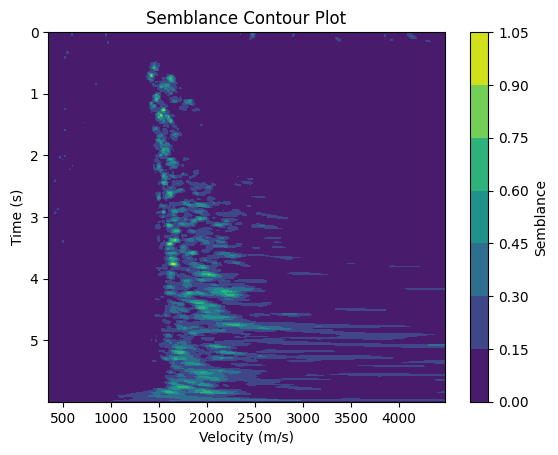

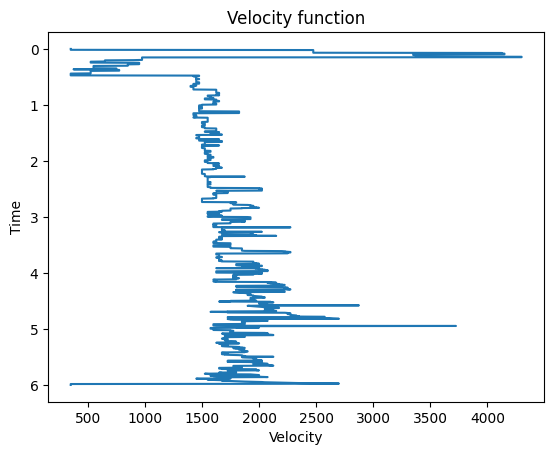

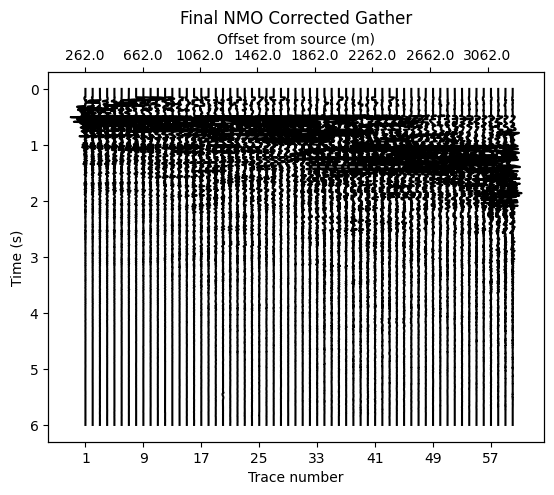

344


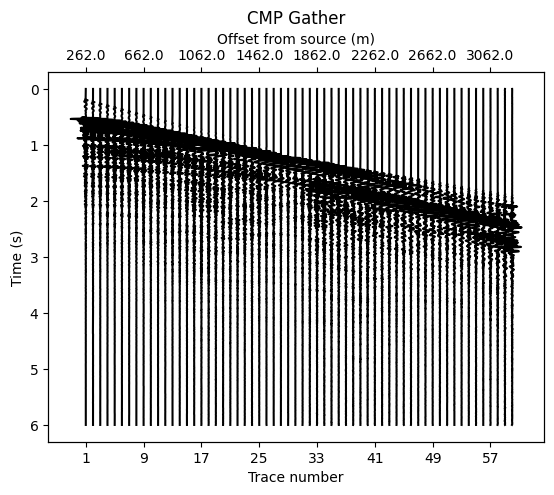

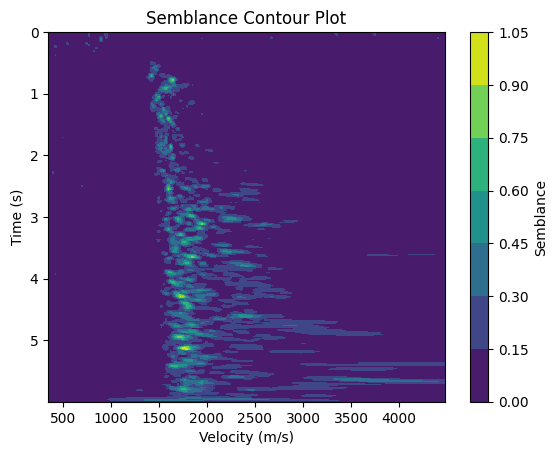

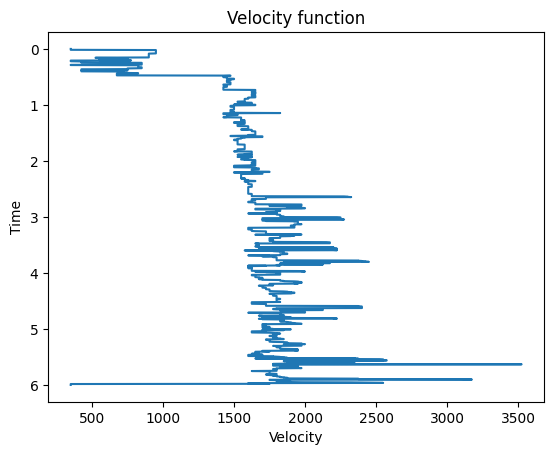

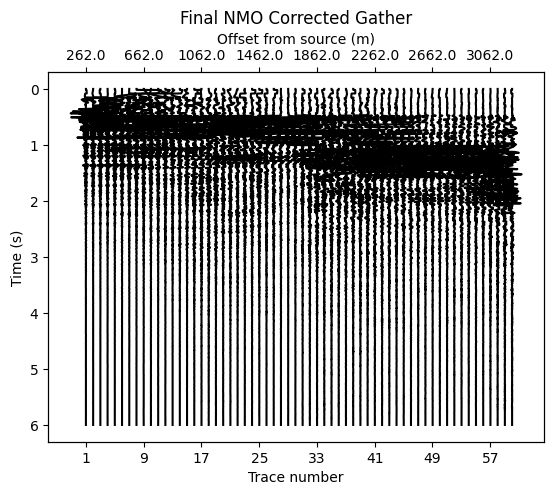

393


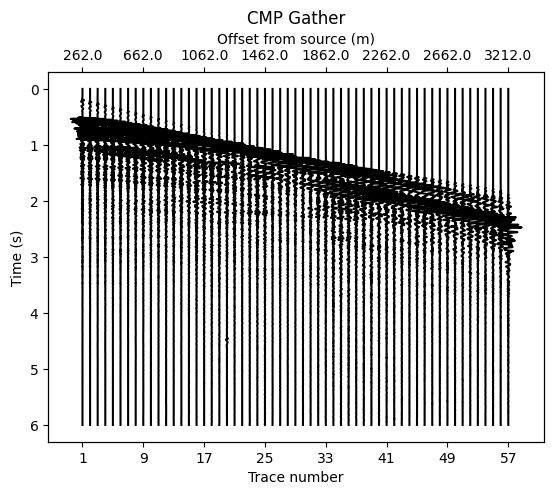

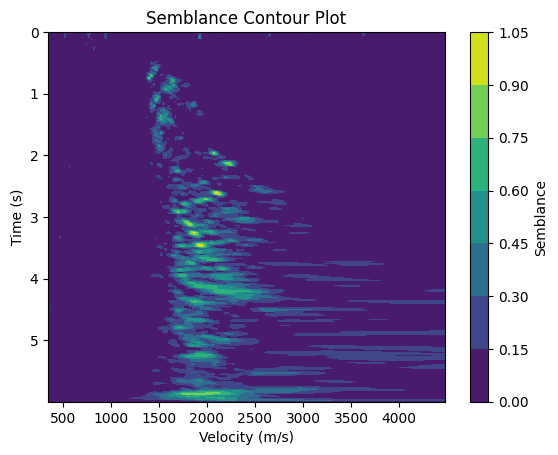

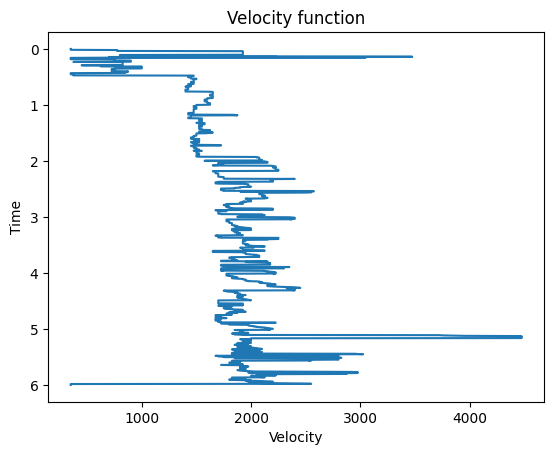

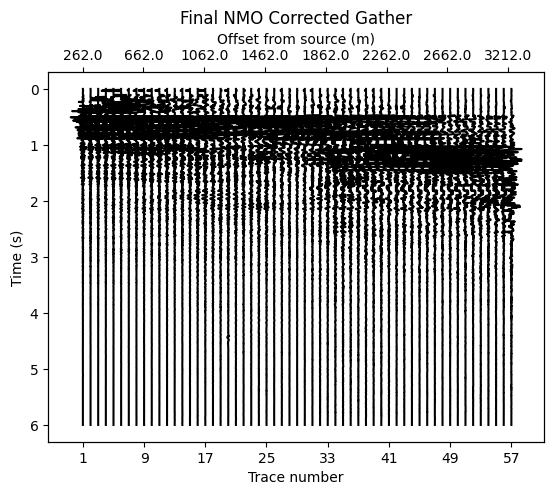

442


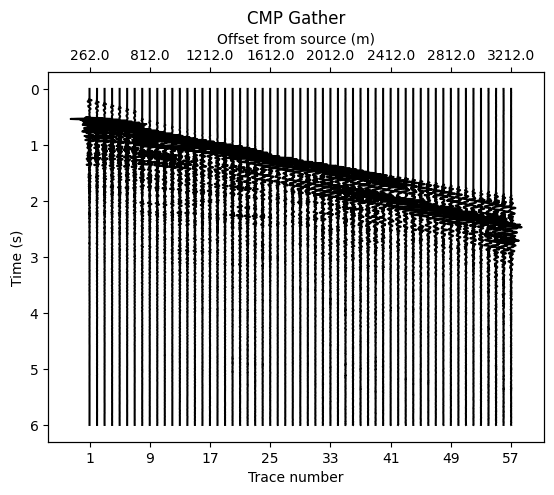

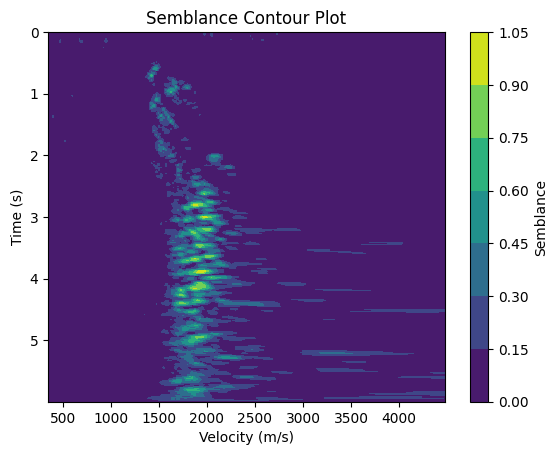

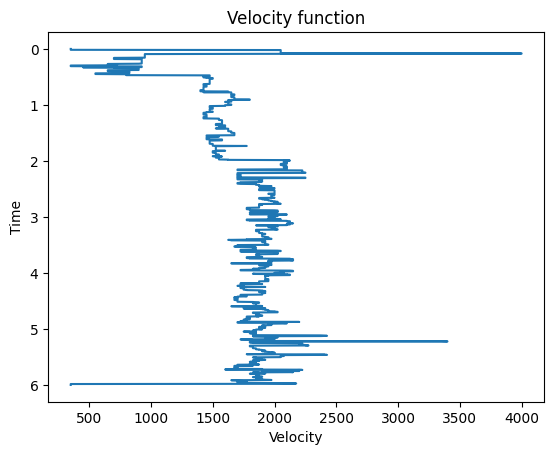

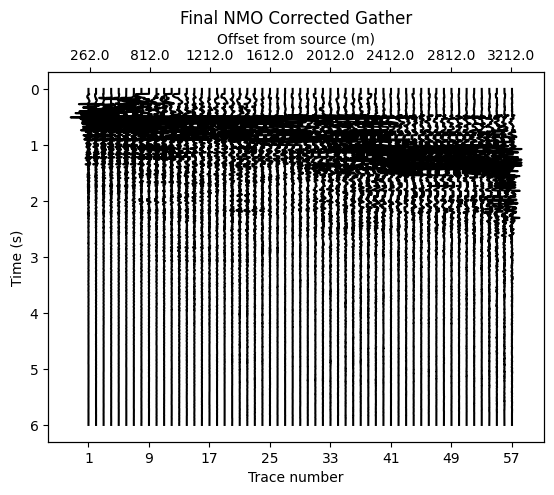

491


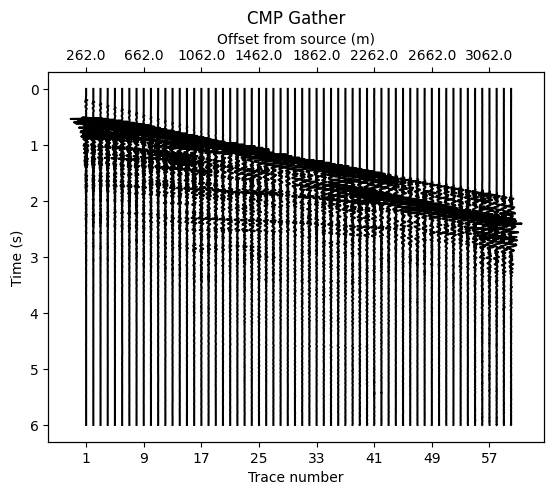

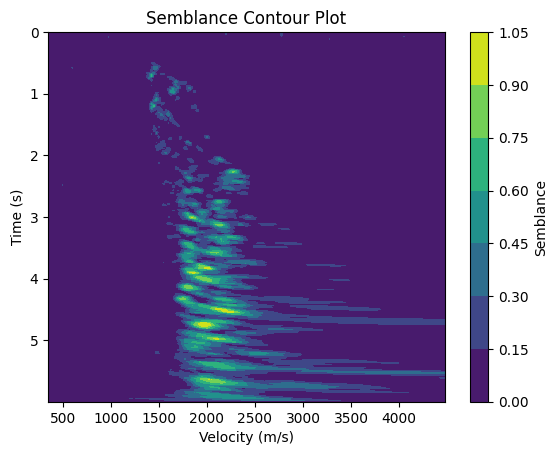

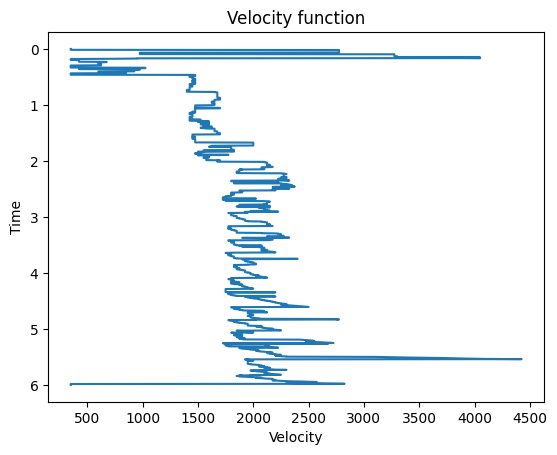

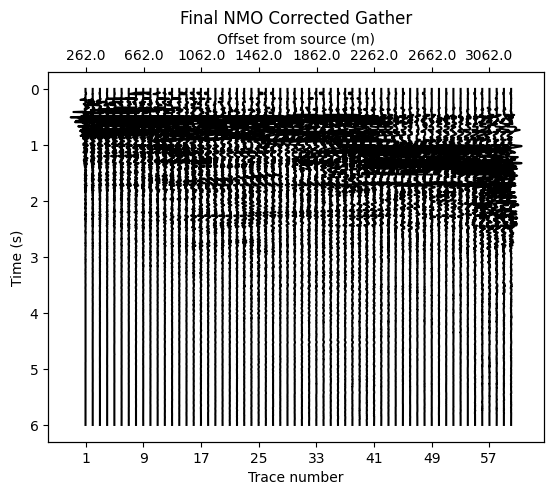

540


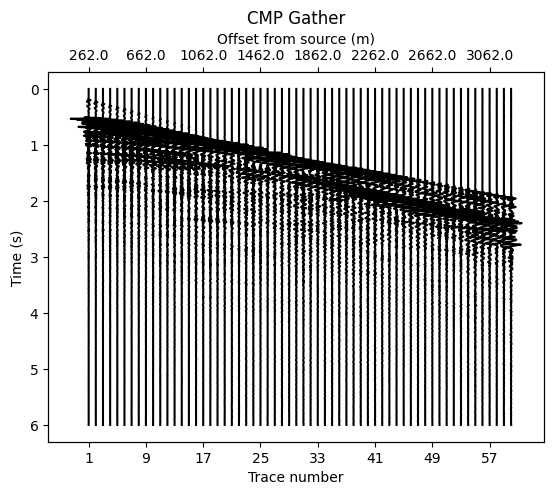

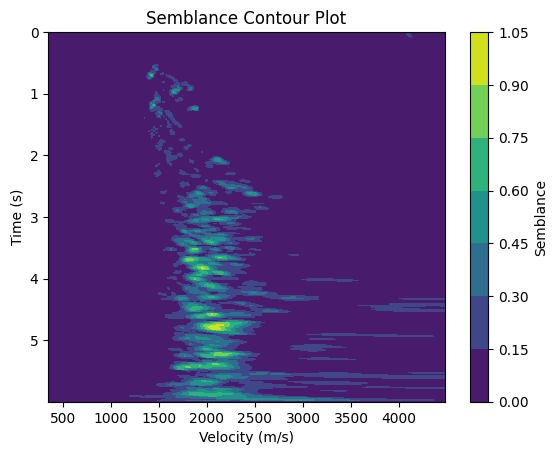

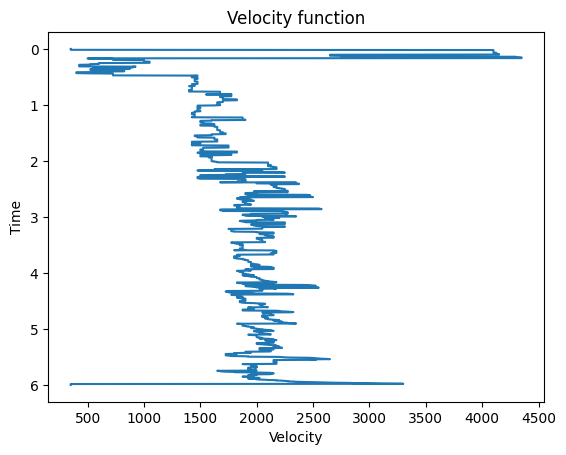

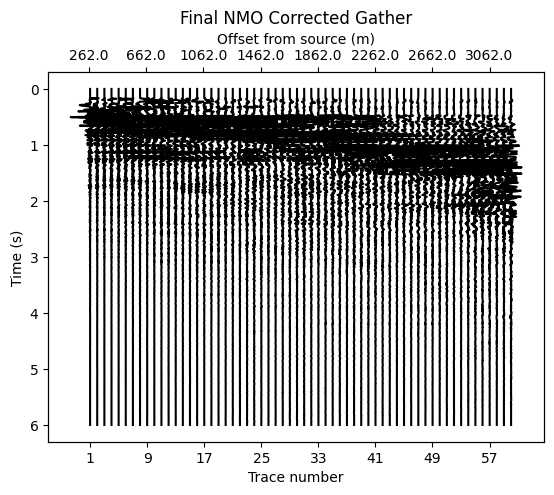

589


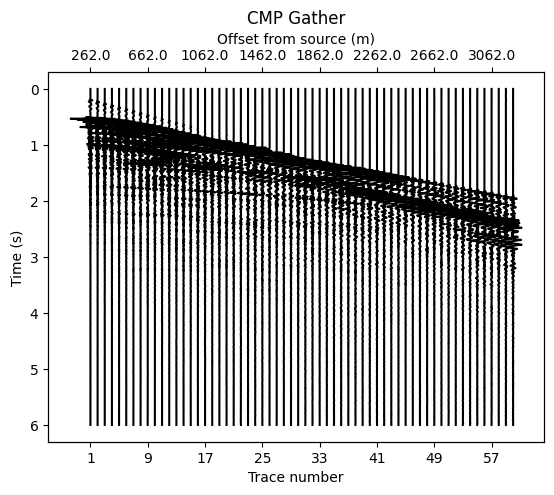

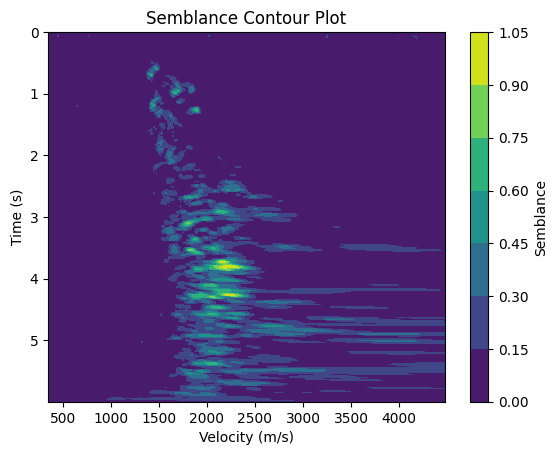

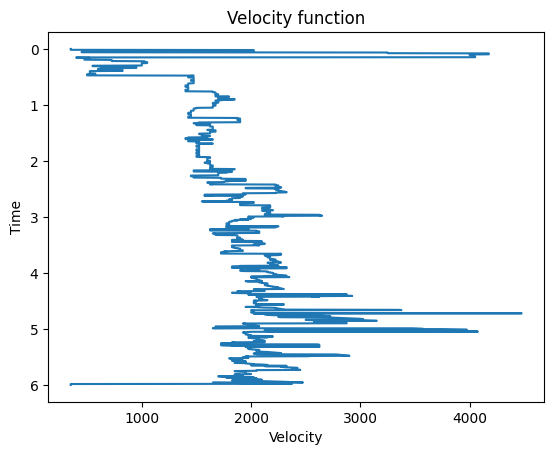

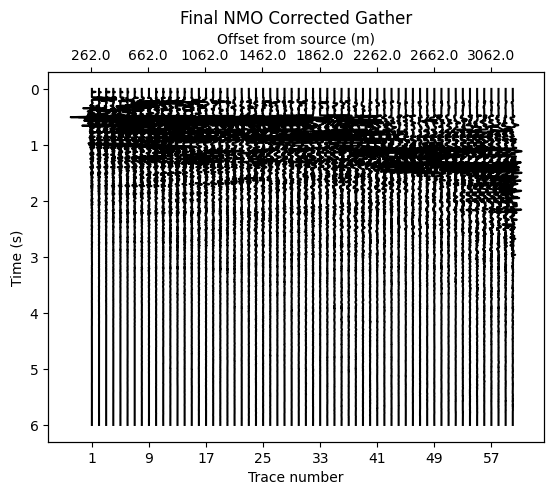

638


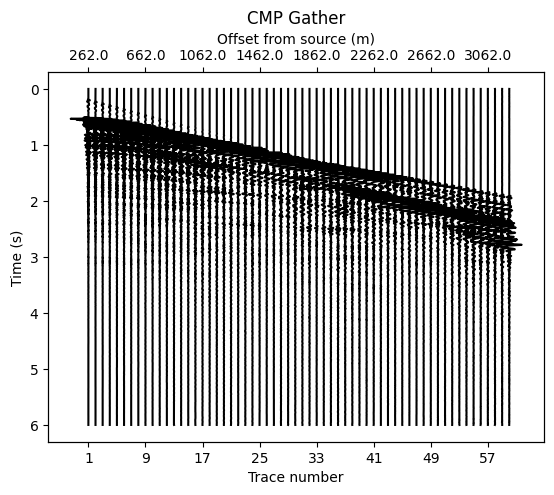

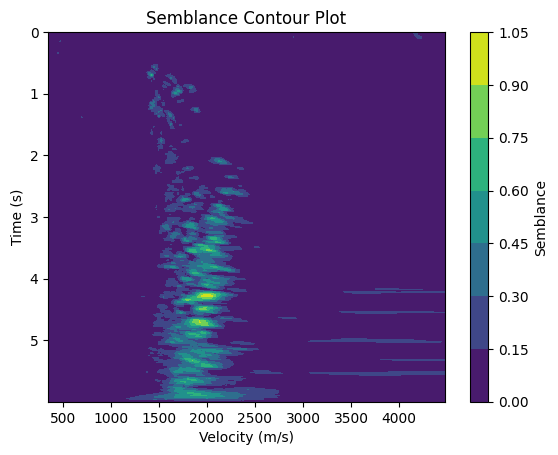

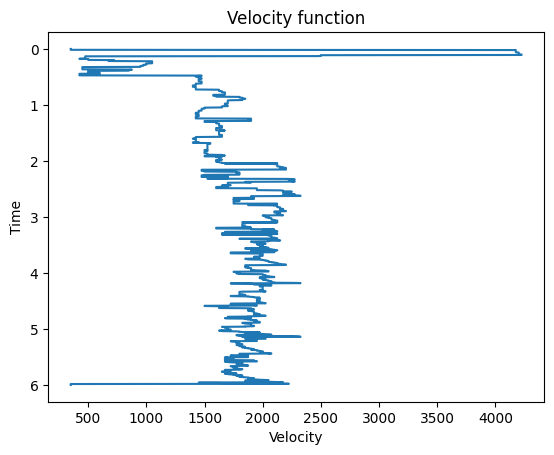

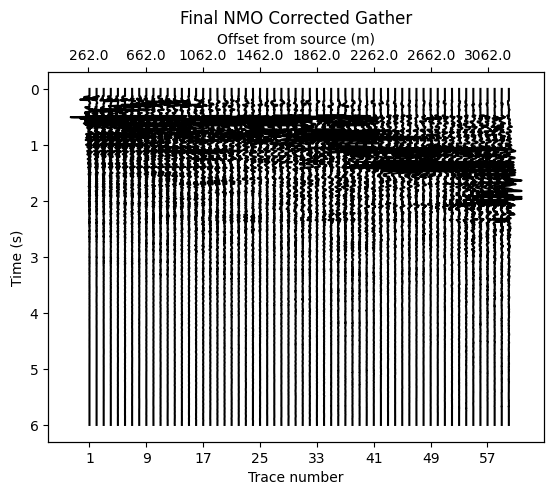

687


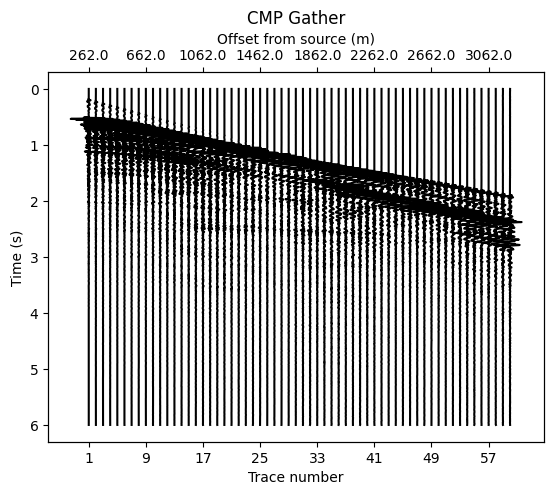

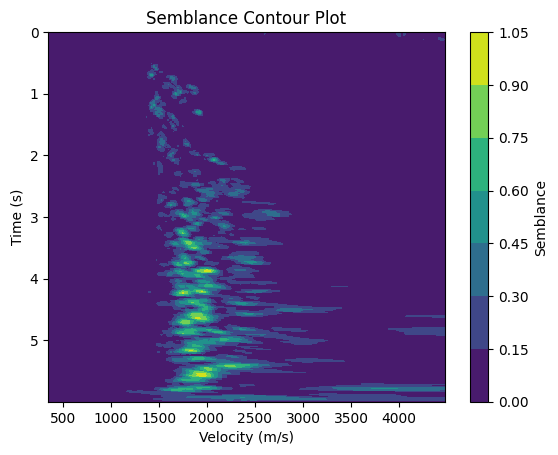

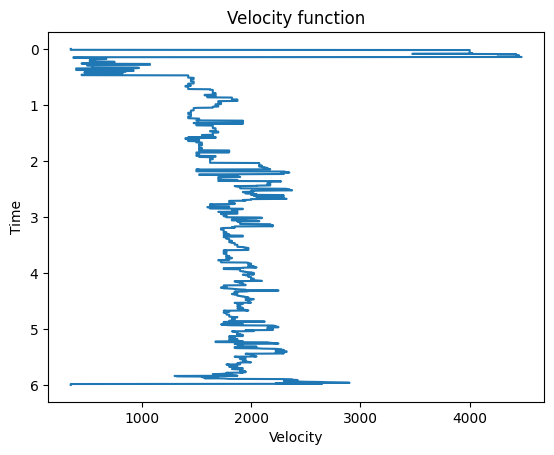

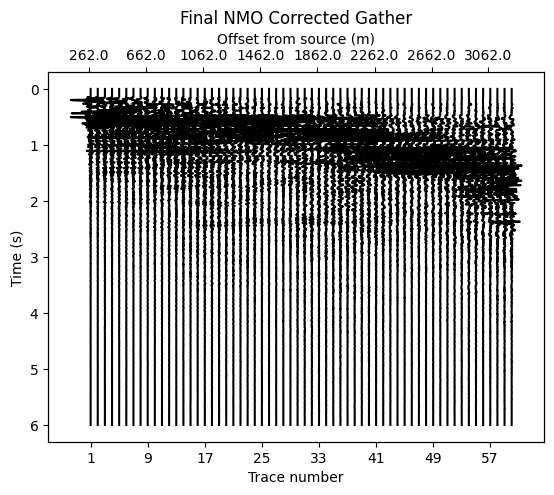

736


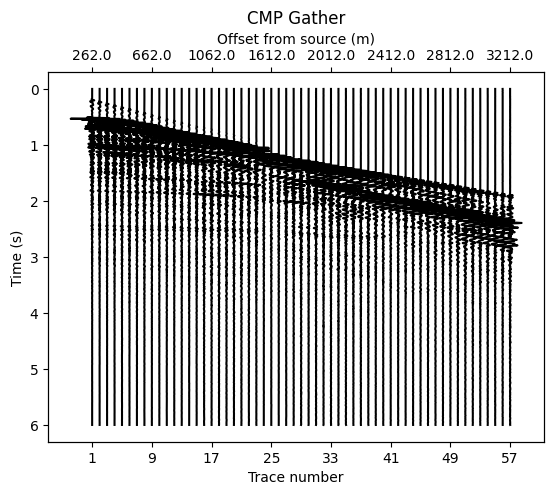

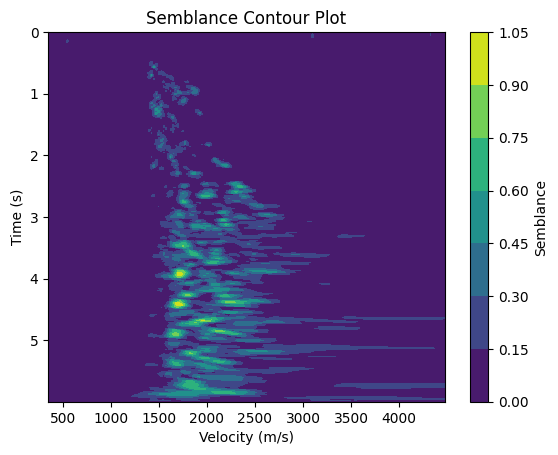

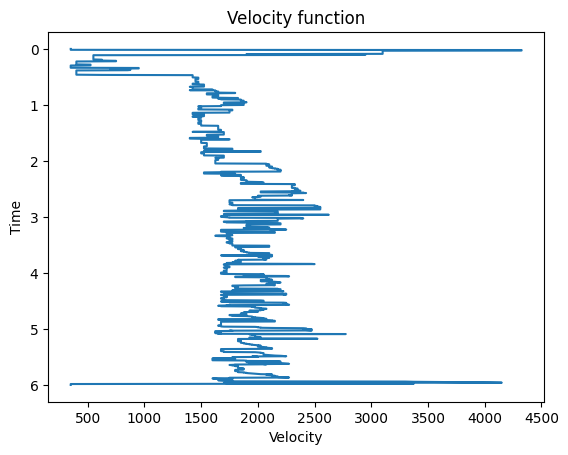

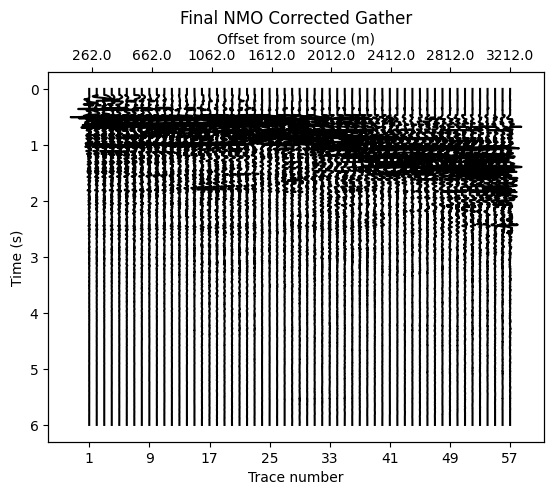

785


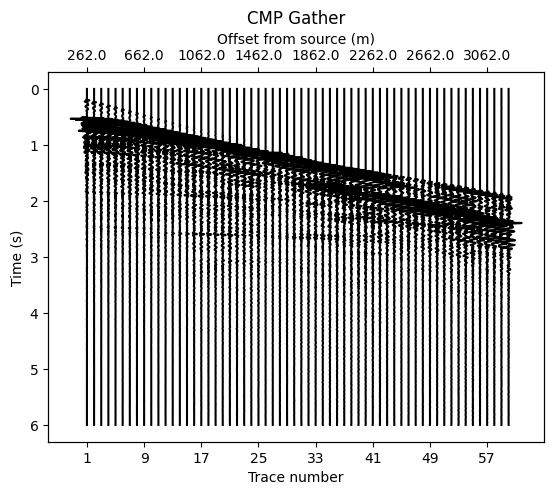

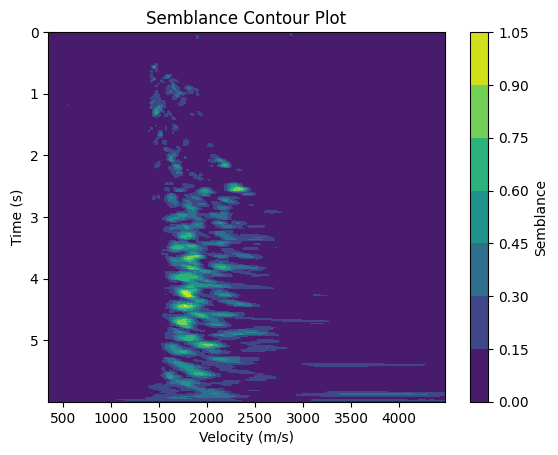

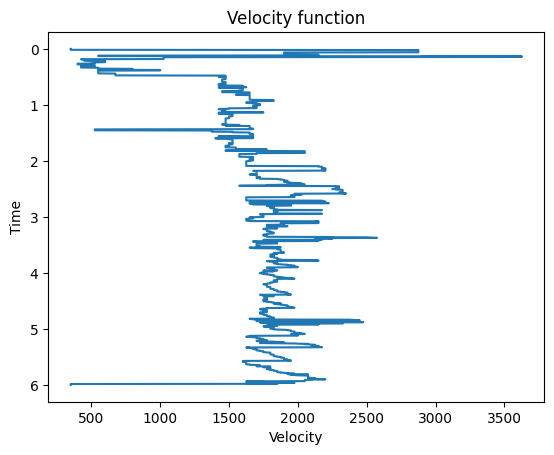

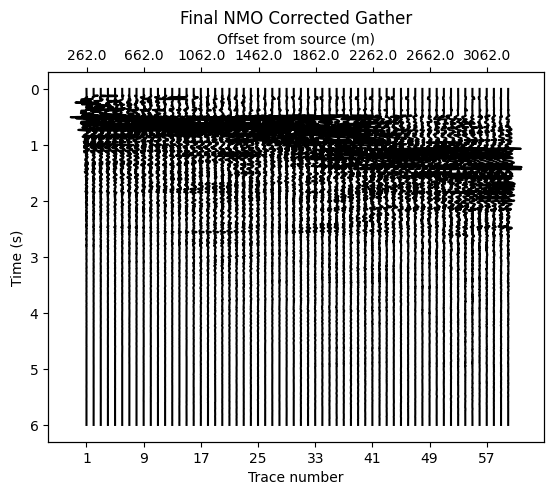

834


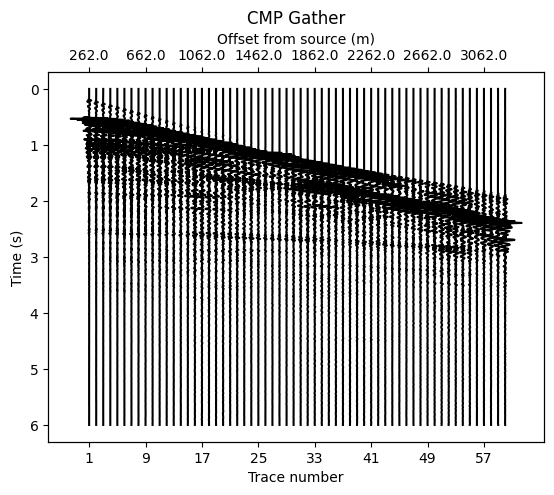

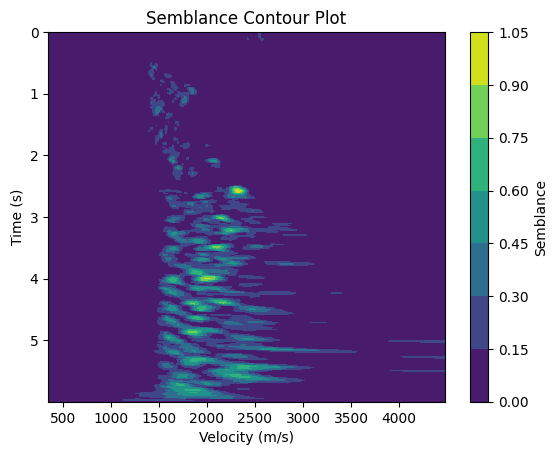

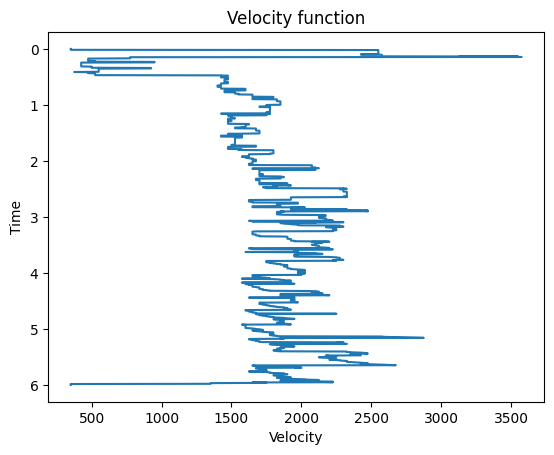

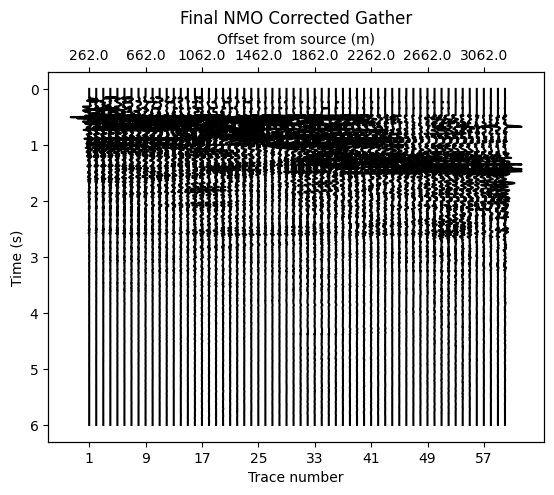

883


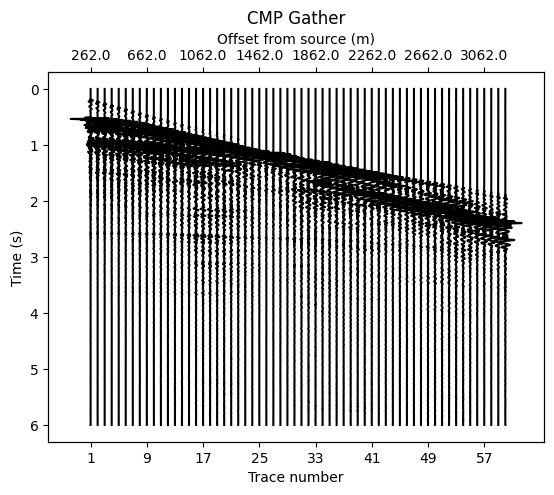

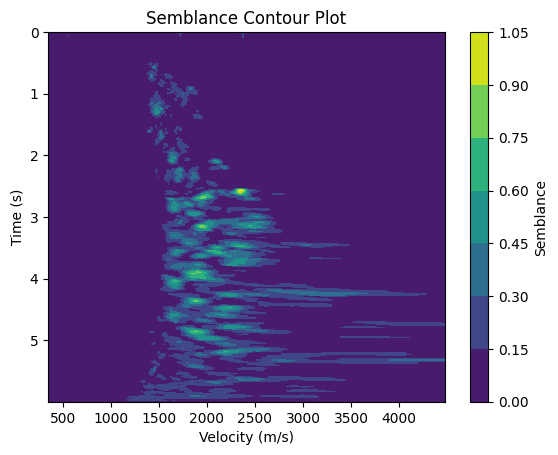

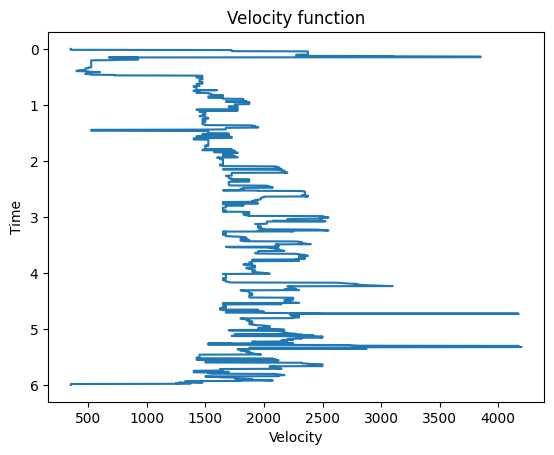

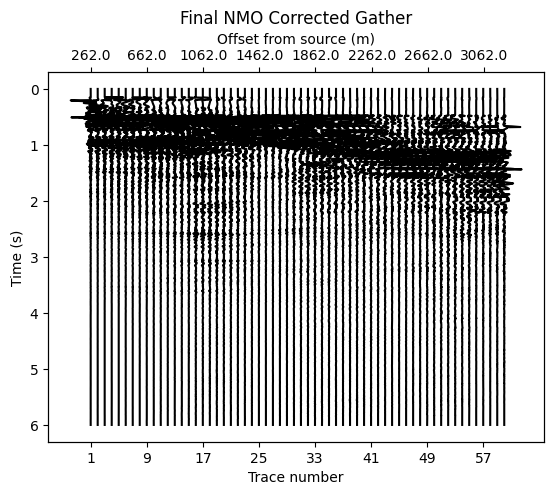

932


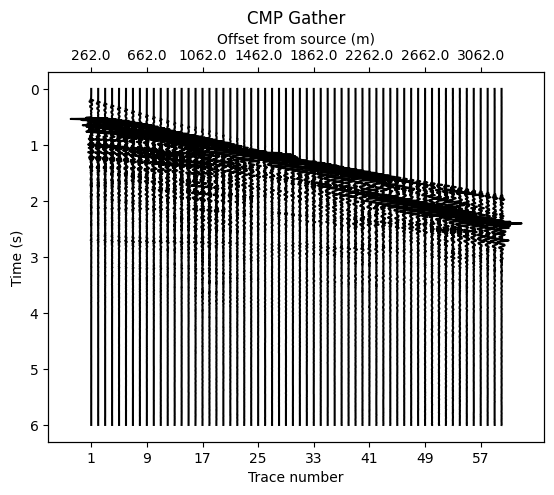

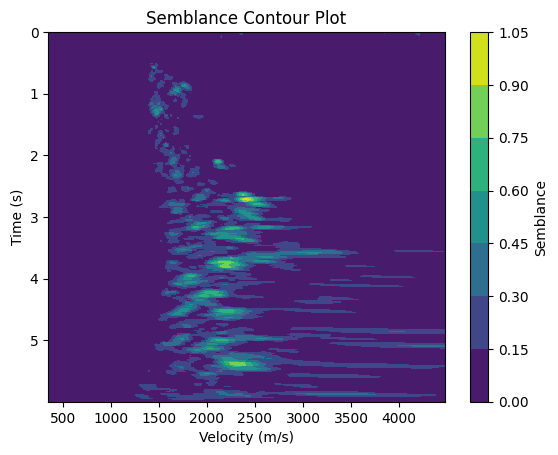

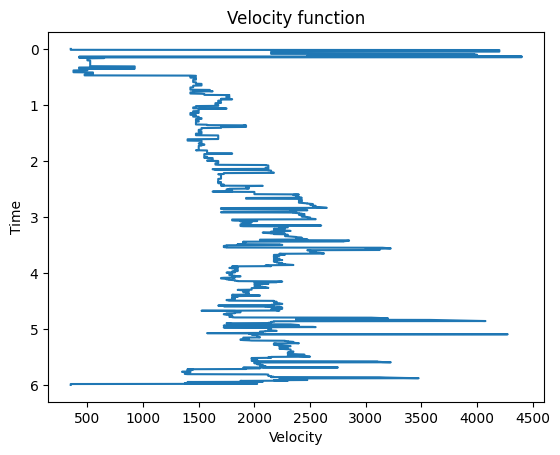

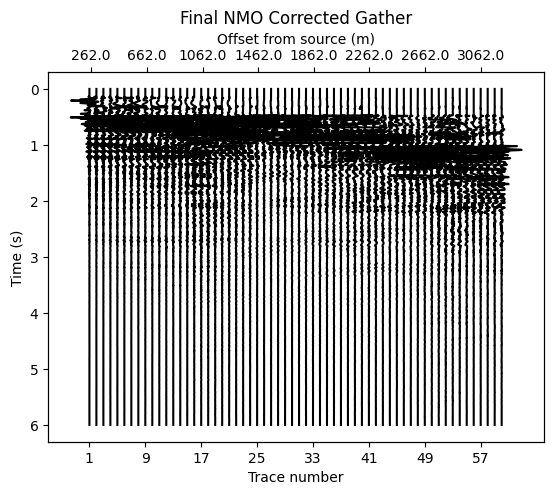

In [32]:
file_semb = 'D:/abdullah/jup/sembs.xlsx'
file_sgs = 'D:/abdullah/jup/sgs.xlsx'
cmp_stack=[]
vel = np.arange(350,4500,25)

for i in range(1,942,49):
    print(i)
    nsheet_name=f'sheet_{i}'

    sg, offsets = extsg(sg2,i)
    # sg = pd.read_excel(file_sgs, sheet_name=nsheet_name)

    sg=sg.values
    # print('sg done')
    # print(sg[2,3])
    sz = sg.shape
    sgn = balance_seismic_data(sg)


### Plotting normalized cmp gather
    
    sn2 = np.zeros_like(sgn)
    for k in range(sz[1]):
        sn2[:,k] = sgn[:,k] + k*5.5


    fig, ax1 = plt.subplots()
    ax1.plot(sn2[:, :sz[1]], t, 'k')
    ax1.invert_yaxis()  # Reverse the y-axis

    # Extract x-tick positions
    xtick_positions = np.mean(sn2[:, list(range(0,sz[1],8))], axis=0) #s2[:, [0, 9, 19, 29, 39, 49, 59]].mean().values
    # Set x-tick marks and labels for the bottom axes
    ax1.set_xticks(xtick_positions)
    ax1.set_xticklabels(list(range(1,sz[1]+1,8)))

    ax2 = ax1.twiny()

    # Set x-tick marks and labels for the top axes
    xtick_positions_top = np.mean(sn2[:, list(range(0,sz[1],8))], axis=0) #s2[:, [0, 9, 19, 29, 39, 49, 59]].mean().values
    ax2.set_xticks(xtick_positions_top)
    ax2.set_xticklabels(offsets.tolist()[0:sz[1]:8])
    
    ax2.set_xlim(ax1.get_xlim())
    
    ax1.set_xlabel('Trace number')
    ax2.set_xlabel('Offset from source (m)')
    
    # Set label for y-axis
    ax1.set_ylabel('Time (s)')
    plt.title('CMP Gather')

    plt.show()
    

### reading semblance values
    semb = pd.read_excel(file_semb, sheet_name=nsheet_name, header=None)
    semb=semb.values

### Plotting semblance contour

    fig, ax3 = plt.subplots()
    contour = ax3.contourf(vel, t, semb / np.max(semb), cmap='viridis')
    ax3.invert_yaxis()  # Reverse the y-axis
    ax3.set_ylabel('Time (s)')
    ax3.set_xlabel('Velocity (m/s)')
    
    plt.title('Semblance Contour Plot')
    
    # Add colorbar using the result of contourf as the mappable
    cbar = plt.colorbar(contour, ax=ax3, label='Semblance')
    
    # Show the plot
    plt.show()

#### Extracing and plotting velocity function with time (from semblance analysis/contour plot)
    mxi = np.argmax(semb, axis=1)
    # Find the maximum values in each row
    mxv = semb[np.arange(len(semb)), mxi]
    velm = vel[mxi] # velocity function

    plt.plot(velm,t)
    plt.gca().invert_yaxis()
    # Add labels and title
    plt.xlabel('Velocity')
    plt.ylabel('Time')
    plt.title('Velocity function')
    plt.show()


### Final NMO correction using velocity function
    final_nmc = f_nmo_correction(sgn, dt, offsets, velm)

    
### Plotting final NMO corrected CMP gather
    sn3 = np.zeros_like(final_nmc)
    for k in range(sz[1]):
        sn3[:,k] = final_nmc[:,k]+k*5.5

    fig, ax4 = plt.subplots()
    ax4.plot(sn3[:, :sz[1]], t, 'k')
    ax4.invert_yaxis()  # Reverse the y-axis

    # Extract x-tick positions
    xtick_positions = np.mean(sn3[:, list(range(0,sz[1],8))], axis=0) #s2[:, [0, 9, 19, 29, 39, 49, 59]].mean().values
    # Set x-tick marks and labels for the bottom axes
    ax4.set_xticks(xtick_positions)
    ax4.set_xticklabels(list(range(1,sz[1]+1,8)))

    ax5 = ax4.twiny()

    # Set x-tick marks and labels for the top axes
    xtick_positions_top = np.mean(sn3[:, list(range(0,sz[1],8))], axis=0) #s2[:, [0, 9, 19, 29, 39, 49, 59]].mean().values
    ax5.set_xticks(xtick_positions_top)
    ax5.set_xticklabels(offsets.tolist()[0:sz[1]:8])
    
    ax5.set_xlim(ax1.get_xlim())
    
    ax4.set_xlabel('Trace number')
    ax5.set_xlabel('Offset from source (m)')
    
    # Set label for y-axis
    ax4.set_ylabel('Time (s)')

    plt.title('Final NMO Corrected Gather')
    plt.show()


### CMP Stacking 
    stack = np.sum(final_nmc, axis=1, keepdims=True)
    stack_bal = balance_seismic_data(stack)
    cmp_stack.append(stack_bal)




Text(0, 0.5, 'Time')

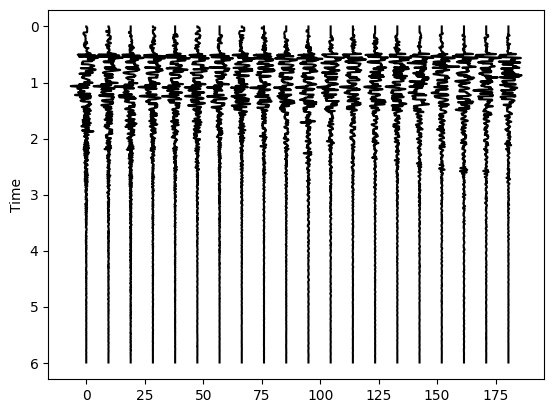

In [36]:
cmp_st = np.column_stack(cmp_stack)
cmp_stk = np.zeros_like(cmp_st)
for i in range((cmp_st.shape[1])):
    cmp_stk[:,i] = cmp_st[:,i]+i*9.5


fig, ax1 = plt.subplots()
ax1.plot(cmp_stk, t, 'k')
ax1.invert_yaxis()  # Reverse the y-axis
plt.ylabel('Time')